# SECOM Yield Prediction — End-to-End Notebook

**Goal:** Predict *Fail* outcomes from process measurements to reduce scrap and downtime.

**Data:** `data/secom.data`, `data/secom_labels.data`, `data/secom.names` (UCI ML Repository, real fab data).

**Primary metric:** Recall on *Fail* at acceptable precision. Report PR-AUC and Balanced Error Rate (BER).

> Safety: No unsupported claims. Treat outputs as decision support, not automation.

### 1. Setup

In [1]:
# Basic libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import joblib


# Global style for plots
plt.rcParams.update({
    "font.family": "Times New Roman",
    "font.size": 12,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "axes.edgecolor": "black",
    "axes.linewidth": 1,
    "xtick.color": "black",
    "ytick.color": "black",
    "xtick.direction": "out",
    "ytick.direction": "out",
    "xtick.bottom": True,
    "ytick.left": True,
    "xtick.top": False,
    "ytick.right": False,
    "figure.dpi": 150,
    "legend.frameon": True,
    "legend.facecolor": "white",
    "legend.edgecolor": "black",
    "legend.fontsize": 12
})

# Apply to seaborn
sns.set_theme(context="notebook", style="ticks")

# Reproducibility
rnd_num = 42
np.random.seed(rnd_num)

# Root directory
ROOT = Path(os.getcwd()).parent

# Data directory
DATA_DIR = Path(ROOT/"data")
RAW = Path(DATA_DIR/"raw")
assert (RAW/"secom.data").exists() and (RAW/"secom_labels.data").exists(), "Data files are missing!"

# Results directory
RESULT_DIR = Path(ROOT/"results")
RESULT_DIR.mkdir(exist_ok=True, parents=True)

# Model directory
MODEL_DIR = Path(ROOT/"models")
MODEL_DIR.mkdir(exist_ok=True, parents=True)

In [2]:
# Figure saver helper (use after each plot)
RESULT_DIR_ETL = Path(RESULT_DIR/"ETL")
RESULT_DIR_ETL.mkdir(exist_ok=True, parents=True)
def savefig(name):
    out = RESULT_DIR_ETL/name
    plt.tight_layout()
    plt.savefig(out, dpi=300, bbox_inches="tight")
    print("Saved:", out)

Note: Numbering continue from 01_EDA.ipynb

### 5. Extract Transform Load (ETL)

In [3]:
# Libraries
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold

In [4]:
# Load data from EDA step.
df_EDA = pd.read_parquet(DATA_DIR/"interim/SECOM_EDA.parquet")
df = df_EDA.copy()
df = df.drop(columns=["timestamp"])  # timestamp not needed for modeling

#### 5.1. Missing value handling (audit + strategy)

From EDA we know:
- Most features have almost no missing values.
- A few have extreme missingness (up to `~91%`).
- Average missingness `~4.5%`.

Saved: /Volumes/MyProjects/GitHub/DataScience/Project3-SECOMSemiconductorYieldPrediction/results/ETL/01_missing_drop_curve.png


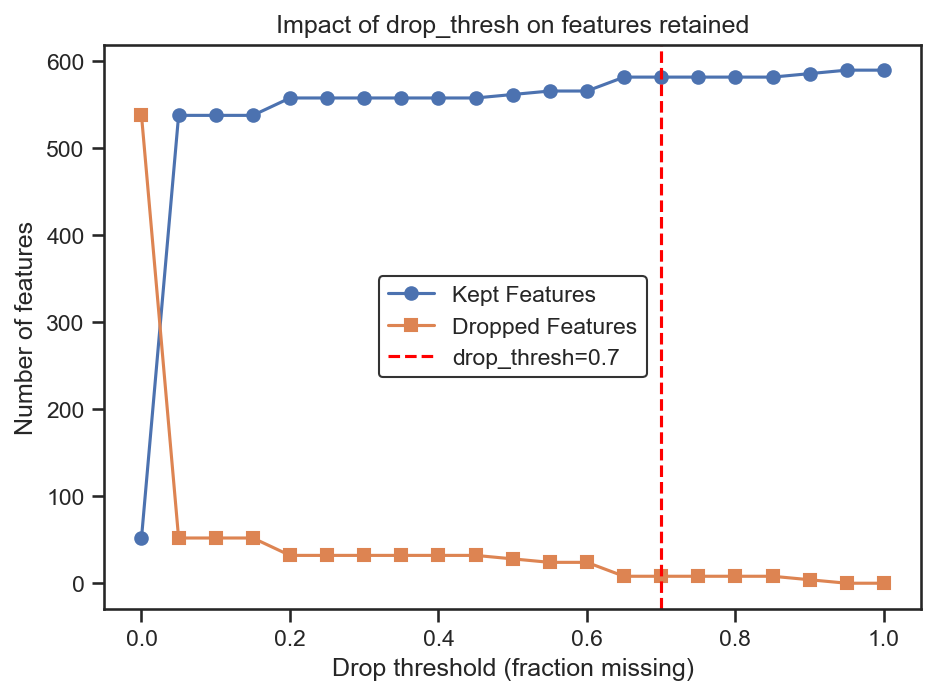

In [5]:
# Fraction of missing per feature
missing_frac = df.drop(columns=["label"]).isna().mean()

# Candidate thresholds to test
thresh_values = np.linspace(0, 1, 21)

kept, dropped = [], []

for t in thresh_values:
    drop_cols = (missing_frac > t).sum()
    keep_cols = (missing_frac <= t).sum()
    dropped.append(drop_cols)
    kept.append(keep_cols)

plt.plot(thresh_values, kept, marker="o", label="Kept Features")
plt.plot(thresh_values, dropped, marker="s", label="Dropped Features")
plt.axvline(0.7, color="red", linestyle="--", label="drop_thresh=0.7")
plt.xlabel("Drop threshold (fraction missing)")
plt.ylabel("Number of features")
plt.title("Impact of drop_thresh on features retained")
plt.legend()
savefig("01_missing_drop_curve.png")

plt.show()

Saved: /Volumes/MyProjects/GitHub/DataScience/Project3-SECOMSemiconductorYieldPrediction/results/ETL/02_missing_flag_curve.png


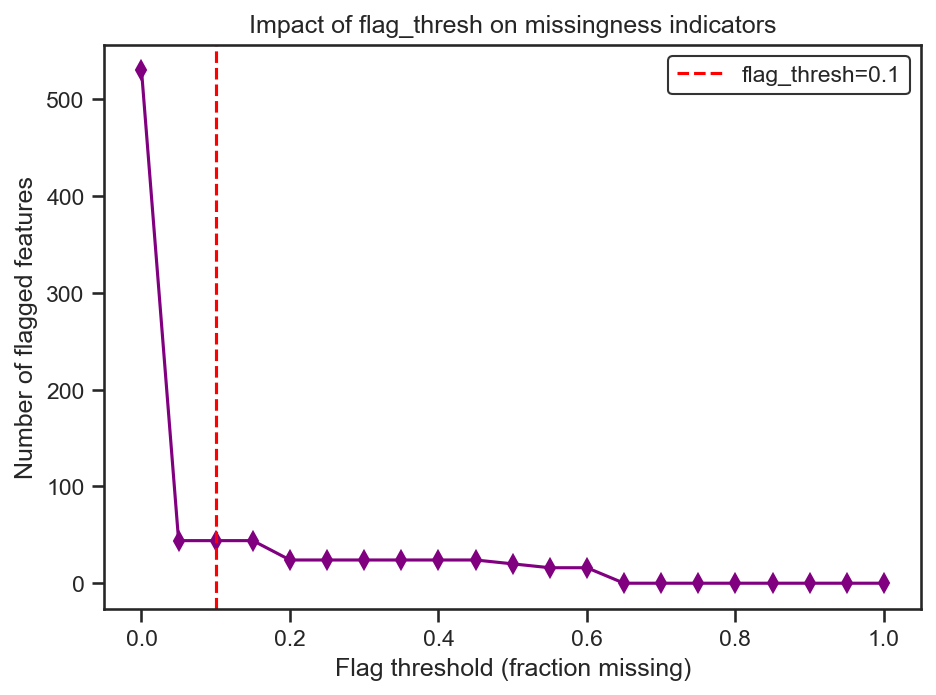

In [6]:
flag_counts = []
for t in thresh_values:
    flag_cols = ((missing_frac > t) & (missing_frac <= 0.7)).sum()
    flag_counts.append(flag_cols)

plt.plot(thresh_values, flag_counts, marker="d", color="purple")
plt.axvline(0.1, color="red", linestyle="--", label="flag_thresh=0.1")
plt.xlabel("Flag threshold (fraction missing)")
plt.ylabel("Number of flagged features")
plt.title("Impact of flag_thresh on missingness indicators")
plt.legend()
savefig("02_missing_flag_curve.png")
plt.show()

In [7]:
# 1. Audit missingness (from EDA)
print(missing_frac.describe())

# 2. Define thresholds
drop_thresh = 0.7   # drop if >70% missing
flag_thresh = 0.1   # add missing indicator if >10% missing

# 3. Identify feature groups
drop_cols = missing_frac[missing_frac > drop_thresh].index.tolist()
flag_cols = missing_frac[(missing_frac > flag_thresh) & (missing_frac <= drop_thresh)].index.tolist()
keep_cols = missing_frac[missing_frac <= drop_thresh].index.tolist()

print(f"Drop {len(drop_cols)} features with >70% missing")
print(f"Flag {len(flag_cols)} features with 10-70% missing")
print(f"Keep {len(keep_cols)} features with <70% missing")

# 4. Drop high-missing features
df_etl = df.drop(columns=drop_cols)

# 5. Add missingness indicators
for col in flag_cols:
    df_etl[col+"_missing"] = df_etl[col].isna().astype(int)

# 6. Impute remaining missing with median
imputer = SimpleImputer(strategy="median")
df_etl[keep_cols] = imputer.fit_transform(df_etl[keep_cols])

print("Shape:", df_etl.shape)

count    590.000000
mean       0.045375
std        0.154340
min        0.000000
25%        0.001276
50%        0.003829
75%        0.005743
max        0.911934
dtype: float64
Drop 8 features with >70% missing
Flag 44 features with 10-70% missing
Keep 582 features with <70% missing
Shape: (1567, 627)


#### 5.2. Outlier Handling.

In [8]:
from scipy.stats import skew

strategies = {}
X = df_etl.drop(columns="label")

for col in X.columns:
    s = X[col].dropna()
    sk = skew(s)
    if abs(sk) > 1 and (s >= 0).all():
        strategies[col] = "log"
    elif s.quantile(0.99) > s.quantile(0.5) * 5:  # extreme tail
        strategies[col] = "winsor"
    else:
        strategies[col] = "keep"

# Summary of counts
from collections import Counter
print(Counter(strategies.values()))

/var/folders/32/g_5ff_b9667068lbxcnk8vzr0000gn/T/ipykernel_37398/2367544623.py:8: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  sk = skew(s)
/var/folders/32/g_5ff_b9667068lbxcnk8vzr0000gn/T/ipykernel_37398/2367544623.py:8: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  sk = skew(s)
/var/folders/32/g_5ff_b9667068lbxcnk8vzr0000gn/T/ipykernel_37398/2367544623.py:8: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  sk = skew(s)
/var/folders/32/g_5ff_b9667068lbxcnk8vzr0000gn/T/ipykernel_37398/2367544623.py:8: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when t

Counter({'log': 325, 'keep': 262, 'winsor': 39})


In [9]:
# Helper functions for outlier handling.
def winsorize_col(s: pd.Series, lower=0.01, upper=0.99):
    """Clip to [lower, upper] quantiles. Works with NaNs."""
    ql, qu = s.quantile(lower), s.quantile(upper)
    return s.clip(lower=ql, upper=qu)

def apply_outlier_transforms(df_in: pd.DataFrame,
                             strategies: dict,
                             winsor=(0.01, 0.99),
                             log_safe=True) -> pd.DataFrame:
    """
    Apply per-column outlier strategy:
        'log'     -> log1p (if non-negative; else fallback to winsor)
        'winsor'  -> clip to quantiles
        'keep'    -> no change
    Non-feature columns like 'label' are passed through unchanged.
    """
    df = df_in.copy()
    feat_cols = [c for c in df.columns if c != "label"]

    # Summary counters
    n_log = n_win = n_keep = n_badlog = 0

    for c in feat_cols:
        strat = strategies.get(c, "keep")

        # Choose action
        if strat == "log":
            s = df[c]
            # If any negatives and log_safe, fallback to winsor
            if log_safe and (s.min(skipna=True) < 0):
                df[c] = winsorize_col(s, *winsor)
                n_badlog += 1; n_win += 1
            else:
                # log1p handles zeros; keep NaNs as-is (assumed imputed earlier)
                df[c] = np.log1p(s)
                n_log += 1

        elif strat == "winsor":
            df[c] = winsorize_col(df[c], *winsor)
            n_win += 1

        else:  # 'keep'
            n_keep += 1

    print(f"Applied transforms --> log: {n_log}, winsor: {n_win} "
          f"(fallbacks from log: {n_badlog}), keep: {n_keep}")
    return df

In [10]:
# --- run on df_etl dataframe ---
df_etl2 = apply_outlier_transforms(df_etl, strategies, winsor=(0.01, 0.99))
print("After outliers handling step:", df_etl2.shape)

Applied transforms --> log: 325, winsor: 39 (fallbacks from log: 0), keep: 262
After outliers handling step: (1567, 627)


In [11]:
# --- Sanity check after ETL Outlier Handiling Step ---

# 1. Identify indicator columns (added in Step 1)
indicator_cols = [c for c in df_etl2.columns if c.endswith("_missing")]

# 2. Original sensor features (those in strategy dict)
sensor_cols = list(strategies.keys())

# 3. Label column
label_col = "label"

# 4. Safety check: All other columns should be accounted for
other_cols = [c for c in df_etl2.columns 
              if c not in indicator_cols and c not in sensor_cols and c != label_col]

# --- Counts ---
print(f"Total columns: {df_etl2.shape[1]}")
print(f"  Sensor features: {len(sensor_cols)}")
print(f"  Indicator features: {len(indicator_cols)}")
print(f"  Label: 1")
print(f"  Other (unexpected): {len(other_cols)}")

# --- Quick data type check ---
print("\nIndicator columns dtype check (should all be int or 0/1):")
print(df_etl2[indicator_cols].dtypes.value_counts())

# --- Sample preview ---
print("\nSample indicator preview (first 5 rows):")
print(df_etl2[indicator_cols].head())

Total columns: 627
  Sensor features: 626
  Indicator features: 44
  Label: 1
  Other (unexpected): 0

Indicator columns dtype check (should all be int or 0/1):
int64      24
float64    20
Name: count, dtype: int64

Sample indicator preview (first 5 rows):
   f072_missing  f073_missing  f109_missing  f110_missing  f111_missing  \
0             1             1             1             1             1   
1             1             1             1             1             1   
2             0             0             1             1             1   
3             0             0             1             1             1   
4             1             1             1             1             1   

   f112_missing  f244_missing  f245_missing  f246_missing  f247_missing  ...  \
0             1             1             1             1             1  ...   
1             1             1             1             1             1  ...   
2             0             1             1         

#### 5.3. Feature Scaling

In [12]:
# Separate features vs label
X = df_etl2.drop(columns="label")
y = df_etl2["label"]

In [13]:
# Identify which columns to scale: numeric sensors only (exclude indicators)
scale_cols = [c for c in X.columns if not c.endswith("_missing")]
scale_cols

['f000',
 'f001',
 'f002',
 'f003',
 'f004',
 'f005',
 'f006',
 'f007',
 'f008',
 'f009',
 'f010',
 'f011',
 'f012',
 'f013',
 'f014',
 'f015',
 'f016',
 'f017',
 'f018',
 'f019',
 'f020',
 'f021',
 'f022',
 'f023',
 'f024',
 'f025',
 'f026',
 'f027',
 'f028',
 'f029',
 'f030',
 'f031',
 'f032',
 'f033',
 'f034',
 'f035',
 'f036',
 'f037',
 'f038',
 'f039',
 'f040',
 'f041',
 'f042',
 'f043',
 'f044',
 'f045',
 'f046',
 'f047',
 'f048',
 'f049',
 'f050',
 'f051',
 'f052',
 'f053',
 'f054',
 'f055',
 'f056',
 'f057',
 'f058',
 'f059',
 'f060',
 'f061',
 'f062',
 'f063',
 'f064',
 'f065',
 'f066',
 'f067',
 'f068',
 'f069',
 'f070',
 'f071',
 'f072',
 'f073',
 'f074',
 'f075',
 'f076',
 'f077',
 'f078',
 'f079',
 'f080',
 'f081',
 'f082',
 'f083',
 'f084',
 'f086',
 'f087',
 'f088',
 'f089',
 'f090',
 'f091',
 'f092',
 'f093',
 'f094',
 'f095',
 'f096',
 'f097',
 'f098',
 'f099',
 'f100',
 'f101',
 'f102',
 'f103',
 'f104',
 'f105',
 'f106',
 'f107',
 'f108',
 'f109',
 'f110',
 'f111',
 

In [14]:
# Fit StandardScaler on numeric features
scaler = StandardScaler()
X_scaled = X.copy()
X_scaled[scale_cols] = scaler.fit_transform(X[scale_cols])

In [15]:
# Final dataset
df_etl3 = X_scaled.join(y)

print("After ETL Feature Scaling:", df_etl3.shape)
print("Mean of first 5 scaled features:")
print(df_etl3[scale_cols].mean().head())
print("Std of first 5 scaled features:")
print(df_etl3[scale_cols].std().head())

After ETL Feature Scaling: (1567, 627)
Mean of first 5 scaled features:
f000    1.623320e-15
f001   -5.076560e-15
f002   -5.713362e-15
f003    1.623320e-15
f004   -8.161946e-17
dtype: float64
Std of first 5 scaled features:
f000    1.000319
f001    1.000319
f002    1.000319
f003    1.000319
f004    1.000319
dtype: float64


#### 5.4. Chronological split (no leakage)

In [16]:
# Pre-req: df_etl3 has features + 'label'
#          df_EDA has a 'timestamp' column aligned by row index

# 1) attach timestamp (align by index)
assert len(df_etl3) == len(df_EDA), "row count mismatch"
df_etl4 = df_etl3.copy()
df_etl4["timestamp"] = df_EDA["timestamp"]

# 2) drop rows with missing timestamps (should be none)
df_etl4 = df_etl4.dropna(subset=["timestamp"])
print("After attaching timestamp:", df_etl4.shape)

After attaching timestamp: (1567, 628)


In [17]:
# 3) sort by time
df_etl4 = df_etl4.sort_values("timestamp").reset_index(drop=True)

# 4) time-based split indices (60/20/20)
n = len(df_etl4)
i_tr  = int(0.60 * n)
i_val = int(0.80 * n)

In [18]:
# 5) build splits
cols_feat = [c for c in df_etl4.columns if c not in ("label","timestamp")]
X_train, y_train = df_etl4.loc[:i_tr-1, cols_feat].values, df_etl4.loc[:i_tr-1, "label"].values
X_val,   y_val   = df_etl4.loc[i_tr:i_val-1, cols_feat].values, df_etl4.loc[i_tr:i_val-1, "label"].values
X_test,  y_test  = df_etl4.loc[i_val:, cols_feat].values, df_etl4.loc[i_val:, "label"].values

In [19]:
# 6) quick sanity
def stats(y):
    return dict(n=len(y), fails=int((y==1).sum()), fail_rate=float((y==1).mean()))
print("Train:", stats(y_train))
print("Val:  ", stats(y_val))
print("Test: ", stats(y_test))

Train: {'n': 940, 'fails': 76, 'fail_rate': 0.08085106382978724}
Val:   {'n': 313, 'fails': 11, 'fail_rate': 0.03514376996805112}
Test:  {'n': 314, 'fails': 17, 'fail_rate': 0.054140127388535034}


In [20]:
# Backup: keep the split DataFrames for inspection
train_df = df_etl4.loc[:i_tr-1, cols_feat + ["label","timestamp"]]
val_df   = df_etl4.loc[i_tr:i_val-1, cols_feat + ["label","timestamp"]]
test_df  = df_etl4.loc[i_val:, cols_feat + ["label","timestamp"]]

#### 5.5. Low-variance and duplicate feature pruning (train-only)

In [21]:
cols_feat # List of feature columns.

['f000',
 'f001',
 'f002',
 'f003',
 'f004',
 'f005',
 'f006',
 'f007',
 'f008',
 'f009',
 'f010',
 'f011',
 'f012',
 'f013',
 'f014',
 'f015',
 'f016',
 'f017',
 'f018',
 'f019',
 'f020',
 'f021',
 'f022',
 'f023',
 'f024',
 'f025',
 'f026',
 'f027',
 'f028',
 'f029',
 'f030',
 'f031',
 'f032',
 'f033',
 'f034',
 'f035',
 'f036',
 'f037',
 'f038',
 'f039',
 'f040',
 'f041',
 'f042',
 'f043',
 'f044',
 'f045',
 'f046',
 'f047',
 'f048',
 'f049',
 'f050',
 'f051',
 'f052',
 'f053',
 'f054',
 'f055',
 'f056',
 'f057',
 'f058',
 'f059',
 'f060',
 'f061',
 'f062',
 'f063',
 'f064',
 'f065',
 'f066',
 'f067',
 'f068',
 'f069',
 'f070',
 'f071',
 'f072',
 'f073',
 'f074',
 'f075',
 'f076',
 'f077',
 'f078',
 'f079',
 'f080',
 'f081',
 'f082',
 'f083',
 'f084',
 'f086',
 'f087',
 'f088',
 'f089',
 'f090',
 'f091',
 'f092',
 'f093',
 'f094',
 'f095',
 'f096',
 'f097',
 'f098',
 'f099',
 'f100',
 'f101',
 'f102',
 'f103',
 'f104',
 'f105',
 'f106',
 'f107',
 'f108',
 'f109',
 'f110',
 'f111',
 

In [22]:
# Work on TRAIN ONLY to avoid leakage
# Use col_feat to extract features for modeling
Xtr_df = train_df[cols_feat]
ytr = train_df["label"]

In [23]:
# 5a) Low-variance filter (std < 1e-8 after scaling ⇒ constant)
vt = VarianceThreshold(threshold=1e-8)
vt.fit(Xtr_df.values)
keep_mask = vt.get_support()
keep_cols_lv = list(np.array(cols_feat)[keep_mask])
print(f"Low-variance removed: {len(cols_feat) - len(keep_cols_lv)}")

Low-variance removed: 122


In [24]:
# 5b) Duplicate columns (exact duplicates on train)
Xtr_lv = Xtr_df[keep_cols_lv]
dups = {}
seen = {}
for c in keep_cols_lv:
    key = tuple(np.round(Xtr_lv[c].values, 8))  # robust equality
    if key in seen:
        dups[c] = seen[key]
    else:
        seen[key] = c
drop_dups = list(dups.keys())
keep_cols_uniq = [c for c in keep_cols_lv if c not in drop_dups]
print(f"Duplicate columns removed: {len(drop_dups)}")

Duplicate columns removed: 38


In [25]:
# Apply to all splits
def apply_colsubset(df, cols):
    return df[cols + ["label","timestamp"]].copy()

In [26]:
train_df5 = apply_colsubset(train_df, keep_cols_uniq)
val_df5   = apply_colsubset(val_df,   keep_cols_uniq)
test_df5  = apply_colsubset(test_df,  keep_cols_uniq)

In [27]:
print("Shapes after Low-variance and duplicate feature pruning:", train_df5.shape, val_df5.shape, test_df5.shape)

Shapes after Low-variance and duplicate feature pruning: (940, 468) (313, 468) (314, 468)


#### 5.6. Correlation pruning (train-only, within highly correlated groups)

In [28]:
# Remove one feature from any pair with |corr| >= 0.98 (train-only)
Xtr = train_df5.drop(columns=["label","timestamp"])
corr = Xtr.corr().abs()

In [29]:
# Upper triangle mask
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
high_corr_cols = [column for column in upper.columns if (upper[column] >= 0.98).any()]

In [30]:
# Keep = all minus high-corr columns
keep_cols_corr = [c for c in Xtr.columns if c not in set(high_corr_cols)]
print(f"Correlation-pruned: {len(Xtr.columns) - len(keep_cols_corr)}")

Correlation-pruned: 91


In [31]:
# Apply to splits
def apply_corrsubset(df, cols):
    return df[cols + ["label","timestamp"]].copy()

In [32]:
train_df6 = apply_corrsubset(train_df5, keep_cols_corr)
val_df6   = apply_corrsubset(val_df5,   keep_cols_corr)
test_df6  = apply_corrsubset(test_df5,  keep_cols_corr)

In [33]:
print("Shapes after Correlation pruning:", train_df6.shape, val_df6.shape, test_df6.shape)

Shapes after Correlation pruning: (940, 377) (313, 377) (314, 377)


#### 5.7. Persist clean artifacts for modeling

In [34]:
PROC = Path("../data/processed")
PROC.mkdir(parents=True, exist_ok=True)

train_df6.to_parquet(PROC/"train.parquet", index=False)
val_df6.to_parquet(PROC/"val.parquet", index=False)
test_df6.to_parquet(PROC/"test.parquet", index=False)

# Also save feature list
feat_final = [c for c in train_df6.columns if c not in ("label","timestamp")]
pd.Series(feat_final, name="features").to_csv(PROC/"features_final.txt", index=False)

print("Saved:", list(PROC.iterdir()))

Saved: [PosixPath('../data/processed/features_final.txt'), PosixPath('../data/processed/test.parquet'), PosixPath('../data/processed/train.parquet'), PosixPath('../data/processed/val.parquet')]
